In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import copy

from tqdm import tqdm
import glob
from PIL import Image

In [2]:
class Image():
    
    def __init__(self, image, landmarks):
        # self.image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        self.image = image
        self.original_image = copy.deepcopy(self.image)
        self.landmarks = landmarks
        self.hash = hash(self)
        
    def getImage(self):
        return self.image
    
    def clearImage(self):
        self.image= copy.deepcopy(self.original_image)
        return self.image
    
    def getLandmarks(self):
        return self.landmarks
    
    def getHash(self):
        return self.hash

In [3]:
def getLandmarksForImage(imagePath):
    cur_landmark = "/".join(str(imagePath).rsplit('/',3)[-3:])[:-4]
    landmark_path = ck_landmarks_path + '/' + cur_landmark + '_landmarks.txt'
    landmarks = np.loadtxt(landmark_path)
    return landmarks


def view_landmarks(landmarks, color='r'):
    xs, ys = list(zip(*landmarks))
    plt.scatter(xs, ys, color=color)
    return 

In [4]:
base_path = "Data/"

In [5]:
ck_data_path = base_path + 'CK_CK+/CK+/cohn-kanade-images'
ck_landmarks_path = base_path + 'CK_CK+/CK+/Landmarks'
ck_image_files = glob.glob(ck_data_path+'/**/*.png', recursive=True)

ck_image_files = ck_image_files[:500]

In [6]:
face_det = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
face_det2 = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_alt2.xml")
face_det3 = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_alt.xml")
face_det4 = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_alt_tree.xml")

def detect_face(f, ld):
    ''' function to detect face, crop the image and resize it and resize the corresponding landmarks too '''
    frame = cv2.imread(f) #Open image
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Convert image to grayscale
    face = face_det.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face2 = face_det2.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face3 = face_det3.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face4 = face_det4.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
#     ld = np.array([np.array(i) for i in ld])
    crop_ld = ld
    #Go over detected faces, stop at first detected face, return empty if no face.
    if len(face) == 1:
        facefeatures = face
    elif len(face2) == 1:
        facefeatures = face2
    elif len(face3) == 1:
        facefeatures = face3
    elif len(face4) == 1:
        facefeatures = face4
    else:
        facefeatures = ""
    for (x, y, w, h) in facefeatures:
        fw, fh = w, h
        if any(ld[:,0] > x+w):
            fw = int(max(ld[:,0]-x))
        if any(ld[:,1] > y+h):
            fh = int(max(ld[:,1]-y))
#         gray = gray[y:y+h, x:x+w] #Cut the frame to size
        gray = gray[y:y+fh+5, x:x+fw+5] #Cut the frame to size to max of landmark with padding of 5px
        ld_rescale_factor = (gray.shape[1]/crop_imsize, (gray.shape[0]/crop_imsize))
        crop_ld = np.array(list(zip(ld[:,0]-x, ld[:, 1]-y)))
    try:
        output = cv2.resize(gray, (crop_imsize, crop_imsize))
        crop_ld = crop_ld/ld_rescale_factor
        cv2.imwrite(crop_path+'/crop_'+f.split('/')[-1], output)
    except:
        output = gray

    return output, crop_ld

In [7]:
images = []
crop_imsize = 350

with tqdm(total=len(ck_image_files), desc="Processing entries") as pbar:
    for i, ck_image in enumerate(ck_image_files):

        landmarks = getLandmarksForImage(ck_image)
        image, landmarks = detect_face(ck_image, landmarks)
        image = cv2.resize(image,(crop_imsize, crop_imsize))
        images.append(Image(image, landmarks))
        
        pbar.update(1)

Processing entries: 100%|██████████| 500/500 [03:06<00:00,  2.68it/s]


# Compute average landmark position

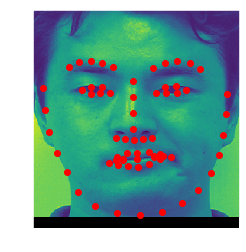

In [8]:
plt.imshow(images[1].getImage())
view_landmarks(images[1].getLandmarks())

In [9]:
numImages = len(images)

avgLandmarks = (images[0].getLandmarks() / numImages)

for image in images[1:]:
    avgLandmarks += (image.getLandmarks()) / numImages

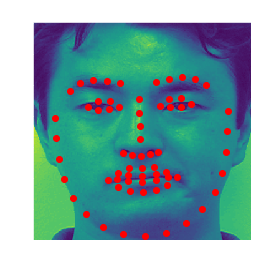

In [10]:
plt.imshow(images[0].getImage())
plt.title("Average Landmarks")
view_landmarks(avgLandmarks)

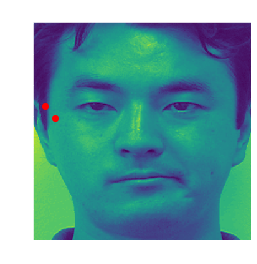

In [11]:
plt.imshow(images[0].getImage())
plt.title("Average Landmarks")
view_landmarks(avgLandmarks[:1])
view_landmarks(images[0].getLandmarks()[:1])

## Transform images to shape free variant

In [17]:
def appendLastRowAsCol(npMatrix):
    return np.c_[npMatrix[:-1,:].T, np.array([npMatrix[-1,:]]).T ]

In [116]:
def pairPlot(im1, im2, clear_figure=False, title=''):
    if not clear_figure:
        plt.figure()
    
    fig, axes = plt.subplots(1,2)
    axes[0].imshow(im1)
    axes[1].imshow(im2)

    fig.suptitle(title, fontsize=16)
    
def getTrianglePts(triangle_points_array):
    return (tuple(triangle_points_array[0:2].astype(np.int32)), tuple(triangle_points_array[2:4].astype(np.int32)), tuple(triangle_points_array[4:6].astype(np.int32)))

def getTriangleImage(im, triangle_points_array):
    pt1, pt2, pt3 = getTrianglePts(triangle_points_array)
    triangle = np.array([pt1, pt2, pt3])
    
    (t_x, t_y, t_w, t_h) = cv2.boundingRect(triangle)
    triangle_im = im[t_y : t_y+t_h, t_x : t_x+t_w]
    triangle_mask = np.zeros_like(triangle_im)

    triangle_mask_fill_points = np.array([
            [pt1[0] - t_x, pt1[1] - t_y],
            [pt2[0] - t_x, pt2[1] - t_y],
            [pt3[0] - t_x, pt3[1] - t_y]
        ], np.int32)
    cv2.fillConvexPoly(triangle_mask, triangle_mask_fill_points, (255,255,255))
        
    cropped_triangle = cv2.bitwise_and(triangle_mask, triangle_im)
    return cropped_triangle

def drawTriangle(im, triangle_points_array, color):
    pt1, pt2, pt3 = getTrianglePts(triangle_points_array)
    
    cv2.line(im, pt1, pt2, color, 2)
    cv2.line(im, pt1, pt3, color, 2)
    cv2.line(im, pt3, pt2, color, 2)

def draw_delaunay(im, subdiv_triangles, color):

    for t in subdiv_triangles:
        drawTriangle(im, t, color)

def get_second_delaunay_triangles(im, src_triangles, src_landmarks, dest_landmarks):
    src_landmarks = np.array(src_landmarks).astype(np.float32)

    dest_triangles = np.array([[1,2,3,4,5,6]])
    for t in src_triangles:
        pt1 = np.array([t[0], t[1]])
        pt2 = np.array([t[2], t[3]])
        pt3 = np.array([t[4], t[5]])
  
        index_pt1 = np.where((pt1 == src_landmarks).all(axis=1))[0][0]
        index_pt2 = np.where((pt2 == src_landmarks).all(axis=1))[0][0]
        index_pt3 = np.where((pt3 == src_landmarks).all(axis=1))[0][0]

        dest_triangle = np.array([dest_landmarks[index_pt1], dest_landmarks[index_pt2], dest_landmarks[index_pt3]]).flatten()
        dest_triangles = np.concatenate((dest_triangles, np.array([dest_triangle])), axis=0)
    
    return dest_triangles[1:]

In [172]:
DRAW_EXAMPLE = True

dest = list(map(lambda x: tuple(x),avgLandmarks))
# dest = list(map(lambda x: tuple(x),images[100].getLandmarks()))

for image in images[:1]:
    src = list(map(lambda x: tuple(x),image.getLandmarks()))
#     tform = cv2.estimateAffine2D(src,dest)
    image.clearImage()
    im = image.getImage()
    im_shape = im.shape

    rect = (0,0,im_shape[1],im_shape[0])
    subdiv = cv2.Subdiv2D(rect)

    subdiv = cv2.Subdiv2D(rect)
    subdiv.insert(src)
    src_triangles = subdiv.getTriangleList()

    dest_triangles = get_second_delaunay_triangles(im, src_triangles, src, dest)

    # draw_delaunay(im, src_triangles[:20], (255,255,255))
    # draw_delaunay(im, dest_triangles, (0,0,0))
    # plt.imshow(im)

    # warped_image_shape = (im_shape[1],im_shape[0])  
    warped_image = np.zeros_like(im)      
    for (src_triangle, dest_triangle) in zip(src_triangles, dest_triangles):
        src_triangle_points = np.array(list(map(lambda x : list(x),getTrianglePts(src_triangle))), np.float32)
        dest_triangle_points = np.array(list(map(lambda x : list(x),getTrianglePts(dest_triangle))), np.float32)
               
        M = cv2.getAffineTransform(src_triangle_points, dest_triangle_points)
      
        src_triangle_image = getTriangleImage(im, src_triangle)

        dest_boundingRect = cv2.boundingRect(dest_triangle_points)
        (dx, dy, dw, dh) = dest_boundingRect
        
        warped_image_triangle = cv2.warpAffine(src_triangle_image, M, (dh, dw))
        # plt.imshow(warped_image_triangle)
        warped_triangle_area = warped_image[dx: dx + dw, dy : dy + dh]        
        warped_triangle_area = cv2.add(warped_triangle_area, warped_image_triangle)

        warped_image[dx: dx + dw, dy : dy + dh] = warped_triangle_area
        
        pairPlot(src_triangle_image, warped_image_triangle)
        break
    # break
    # plt.imshow(warped_image)
        # break
#         if DRAW_EXAMPLE:
            
#             drawTriangle(im, src_triangle, (255,0,0))
#             pairPlot(src_triangle_image, im, title='src')

#             im = image.clearImage()
#             drawTriangle(im, dest_triangle, (255,0,0))
#             dest_triangle_image = getTriangleImage(im, dest_triangle)
#             pairPlot(dest_triangle_image, im, title='dest')
#             break

#     if DRAW_EXAMPLE:
#         break

ValueError: could not broadcast input array from shape (31,42) into shape (42,31)

In [187]:
images[:3]